# Group 49 Project Proposal: User Knowledge

***

### Introduction

We chose the User Knowledge dataset, which gives the students’ knowledge level per user - very low, low, middle, or high - based on their study times and exam performances - given in decimals between 0 and 1 - to do classification.
The question we will try to answer with our project is, **“Given the amount of time spent studying and the exam score of the students, does the student have very low, low, middle, or high knowledge?”**
We will use the training dataset to do this and test the accuracy using the test data.

***



### Preliminary Exploratory Data Analysis

#### Loading Libraries
Loading all libraries that might be required at some point later on in the analysis. 

In [8]:
library(readxl)  #for excel sheet read system
library(DBI)  #for Reading Data from SQLite database
library(dbplyr)  #SQL Database queries functions
library(RSQLite)  #RSQL Database queries functions
library(RPostgres) # RPostgres Database functions
library(tidyverse)  #most of our tidyverse functions 
library(scales)  #for labeling comma function and log scales?
library(RColorBrewer)  #color palette (includes color-blind options)
library(svglite)  #to save svg files
library(repr)  #ggplot visualization + options(repr.plot.width=8, repr.plot.height=7)
library(lubridate) #convert different time/date formatss

ERROR: Error in library(svglite): there is no package called ‘svglite’


#### Reading the dataset into R 
To read the training dataset into R, we used the read_csv function and selected the relevant columns: 

In [12]:
training_data <- read_csv("knowledge_training_data.csv") %>%
select("STG", "STR", "SCG", "LPR", "PEG", "UNS")

training_data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,STR,SCG,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.000,0.00,0.00,very_low
0.08,0.10,0.080,0.24,0.90,High
0.06,0.05,0.060,0.25,0.33,Low
0.10,0.15,0.100,0.65,0.30,Middle
0.08,0.08,0.080,0.98,0.24,Low
0.09,0.40,0.150,0.10,0.66,Middle
0.10,0.43,0.100,0.29,0.56,Middle
0.15,0.34,0.020,0.40,0.01,very_low
0.20,0.35,0.140,0.72,0.25,Low


#### Cleaning and Wrangling into a Tidy Format
We believe this data is tidy because each variable forms a column, each observation forms a row, and each cell is a single measurement. The data was checked for any missing data (NA) and none are present. 

In [13]:
sum(is.na(training_data))

[1] 0

#### Exploratory Data Analysis
We took a count of our training data into a table that groups the data by the UNS (user knowledge level) column and summarizes by counting how many students there are for each level (very_low, Low, Middle, High). Next, we visualised this data with a bar chart ~~with UNS on the x axis and the student count on the y axis, and made it more readable by labelling the axes and title as well as adding a legend according coloured the bars according to their UNS.~~

UNS,n
<chr>,<int>
High,63
Low,83
Middle,88
very_low,24


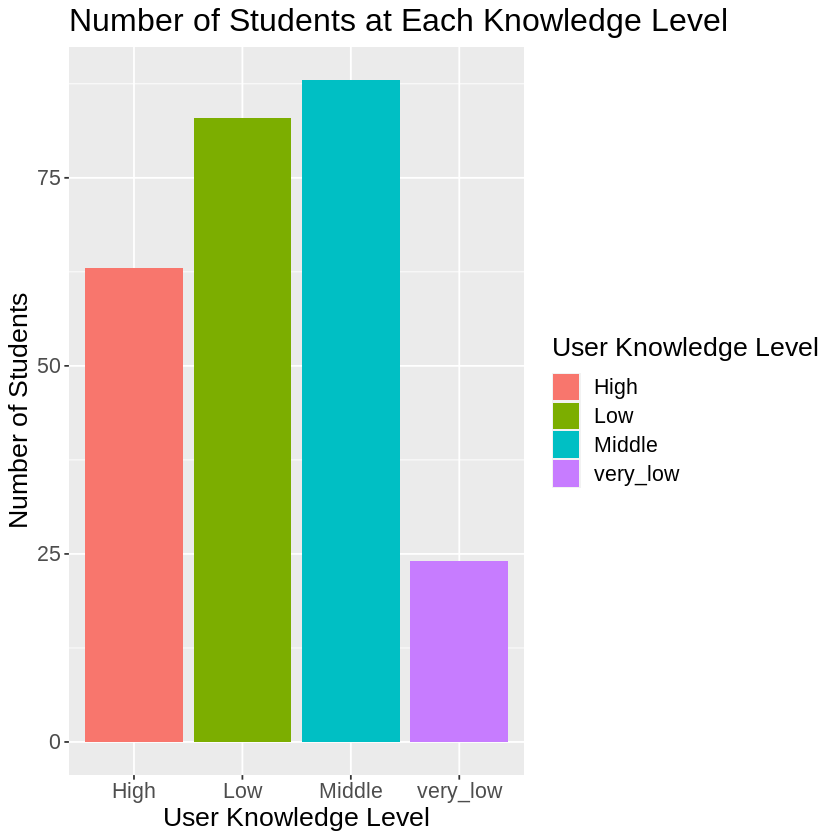

In [29]:
training_grouped <- training_data |>
                    group_by(UNS) |>
                    summarize(n = n())
              

training_grouped

training_grouped_bar <- training_grouped |>
        ggplot(aes(x = UNS, y = n, fill = UNS)) +
        geom_bar(stat = "identity") +
        labs(x = "User Knowledge Level", y = "Number of Students", 
             fill = "User Knowledge Level", title = "Number of Students at Each Knowledge Level") +
        theme(text = element_text(size = 16))

training_grouped_bar

## NEED TO TALK ABOUT WHAT WE DID NEXT...

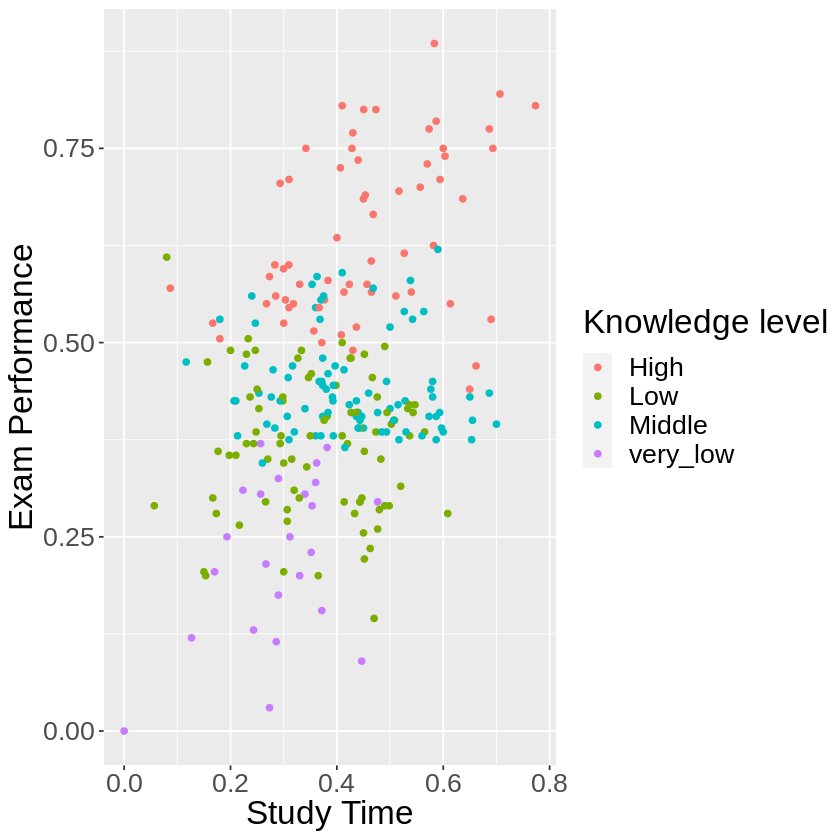

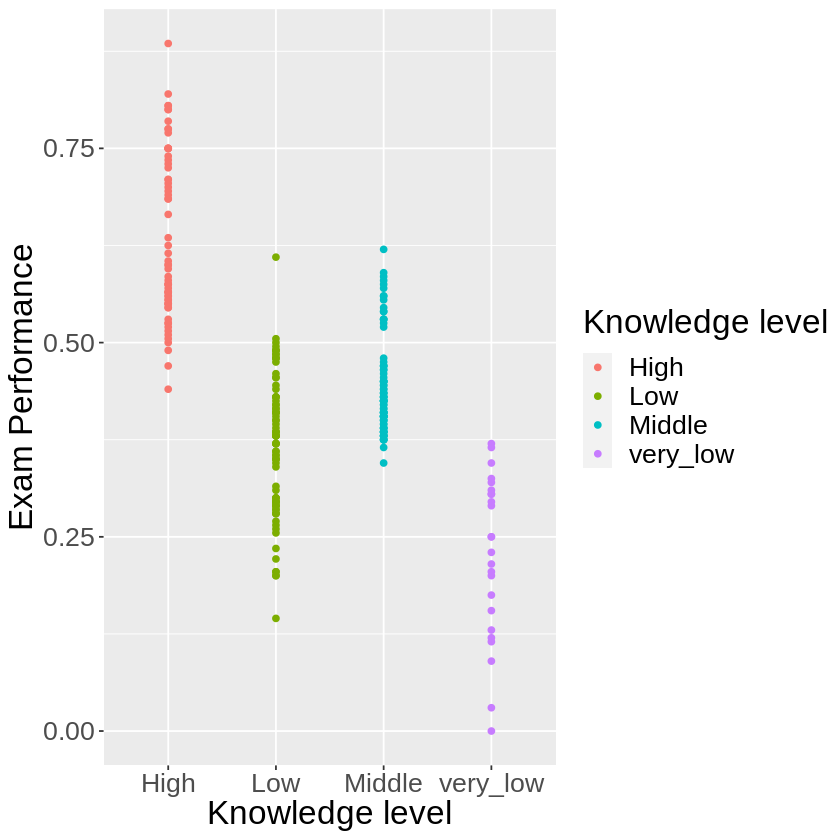

In [30]:

training_mutated <- training_data %>%
mutate(study_avg = ((STG + STR + SCG)/3)) %>%
mutate(exam_avg = ((LPR + PEG)/2))

training_plot <- training_mutated |>
ggplot(aes(x = study_avg, y = exam_avg, color = UNS)) +
geom_point() +
labs(x = "Study Time", y = "Exam Performance", color = "Knowledge level") +
theme(text = element_text(size=20))
training_plot


training_mutated2 <- training_data %>%
mutate(exam_avg = ((LPR + PEG)/2))

training_plot <- training_mutated2 |>
ggplot(aes(x = UNS, y = exam_avg, color = UNS)) +
geom_point() +
labs(x = "Knowledge level", y = "Exam Performance", color = "Knowledge level") +
theme(text = element_text(size=20))
training_plot


***
### Methods

The data analysis method will follow the classification data flow and utilize the tidy models library to train, fit, and test our model in order to predict categorical observations for our question. The variables in this dataset are mainly categorized around repetition and time studied, as well as exam performance. We will be utilizing all of the variables listed below as they are all relevant and applicable to developing a reasonable model that provides rigorous predictions for our question.   

* The degree of study time for goal object materials (STG)
* The degree of repetition number of user for goal object materials (SCG)
* The degree of study time of user for related objects with goal object (STR)
* The exam performance of user for related objects with goal object (LPR)
* The exam performance of user for goal objects (PEG)
* The knowledge level of user (UNS)  

# One method for visualizing the results will be to create a cloud plot to summarize   

***

### Expected Outcomes and Significance  

We expect to find better user knowledge for students with greater study times and higher exam performances. We are predicting that more time spent on a subject usually means better knowledge, but higher exam scores may have a stronger correlation to better knowledge. This is because it is possible to have poor knowledge of a subject even after spending a lot of time studying it if the individual has an ineffective study strategy, whereas it is necessary to have good knowledge of the subject to get a high score on the exam. 
If our prediction is correct, findings may encourage students to find more efficient ways to study as opposed to just spending a lot of time using ineffective study strategies.

Future questions could be: 
* What is the most effective method of studying to consistently yield high exam scores?
* What is the most effective method of studying for individuals to retain information long-term?

***